In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# loading the dataset
columns=['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
train_data = pd.read_csv('/kaggle/input/liardl/train.tsv', sep='\t', header=None, names=columns,index_col=False)
test_data = pd.read_csv('/kaggle/input/liardl/test.tsv', sep='\t', header=None, names=columns,index_col=False)
valid_data = pd.read_csv('/kaggle/input/liardl/valid.tsv', sep='\t', header=None, names=columns,index_col=False)

In [3]:
X_train = train_data['statement']
y_train = train_data['label']
X_test = test_data['statement']
y_test = test_data['label']
X_valid = valid_data['statement']
y_valid = valid_data['label']
X_train[0]


'Says the Annies List political group supports third-trimester abortions on demand.'

In [4]:
print("Train data shape: ",X_train.shape)

Train data shape:  (10240,)


In [5]:
X_train = X_train.values.tolist()
y_train = y_train.values.tolist()
X_test = X_test.values.tolist()
y_test = y_test.values.tolist()
X_valid = X_valid.values.tolist()
y_valid = y_valid.values.tolist()

In [6]:
# Tokenization using bert tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize the sentences
max_length = 128
X_train = tokenizer(X_train, padding=True, truncation=True, max_length=max_length)
X_test = tokenizer(X_test, padding=True, truncation=True, max_length=max_length)
X_valid = tokenizer(X_valid, padding=True, truncation=True, max_length=max_length)

# append 0 to the valid set at the end of the sentence to make it equal to the max length
X_valid['input_ids'] = np.array(X_valid['input_ids'])
X_valid['attention_mask'] = np.array(X_valid['attention_mask'])
X_valid['input_ids'] = np.append(X_valid['input_ids'], np.zeros((len(X_valid['input_ids']), max_length - len(X_valid['input_ids'][0]))), axis=1)
X_valid['attention_mask'] = np.append(X_valid['attention_mask'], np.zeros((len(X_valid['attention_mask']), max_length - len(X_valid['attention_mask'][0]))), axis=1)


# make 6 labels into 2 labels (true, false)
labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
y_train = [labels.index(s) for s in y_train]
y_test = [labels.index(s) for s in y_test]
y_valid = [labels.index(s) for s in y_valid]

for i in range(len(y_train)):
    if y_train[i] <= 2:
        y_train[i] = 1
    else:
        y_train[i] = 0
        
for i in range(len(y_test)):
    if y_test[i] <= 2:
        y_test[i] = 1
    else:
        y_test[i] = 0
        
for i in range(len(y_valid)):
    if y_valid[i] <= 2:
        y_valid[i] = 1
    else:
        y_valid[i] = 0
        
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_valid = torch.tensor(y_valid)

# 1 for true news , 0 for false news


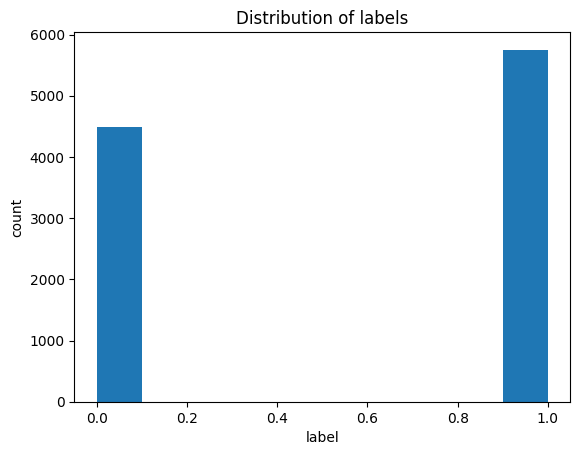

In [7]:
# plot the distribution of labels
plt.hist(y_train)
plt.title('Distribution of labels')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

In [8]:
# find the maximum length of the sentences
max_len = 0
for sent in X_valid['input_ids']:
    if len(sent) > max_len:
        max_len = len(sent)
        
print('Max train sentence length: ', max_len)

min_len = 1000
for sent in X_valid['input_ids']:
    if len(sent) < min_len:
        min_len = len(sent)

print('Min train sentence length: ', min_len)

Max train sentence length:  128
Min train sentence length:  128


In [9]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(torch.tensor(X_train['input_ids']), torch.tensor(X_train['attention_mask']), y_train)
test_dataset = TensorDataset(torch.tensor(X_test['input_ids']), torch.tensor(X_test['attention_mask']))
valid_dataset = TensorDataset(torch.tensor(X_valid['input_ids']), torch.tensor(X_valid['attention_mask']), y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [10]:
# build a lstm model which takes bert embedding as input
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        self.embedding = nn.Embedding(input_dim, 768)
        self.lstm1 = nn.LSTM(768, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim * self.n_directions, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_1 = self.lstm1(embedded)
        output, (hidden, cell) = lstm_1
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1).unsqueeze(0)
        hidden = self.dropout(hidden)
        out = self.fc(hidden.squeeze(0))
        out1 = torch.sigmoid(out)
        return out1
    
model = LSTM(30522, 256, 1, 3, True, 0.5)
model.cuda()
# use focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.3, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)
    
criterion = FocalLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# use sgd as optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

In [11]:
def accuracy(preds, y):

    correct = (preds == y)
    acc = correct.sum() / len(correct)
    return acc

In [12]:
# training
epochs = 15
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
best_valid_loss = float('inf')
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    valid_loss = 0
    valid_acc = 0
    model.train()
    for input_ids, attention_mask, labels in train_dataloader:
        optimizer.zero_grad()
        input_ids = input_ids.long()
        input_ids = input_ids.cuda()
        labels = labels.cuda()
        output = model(input_ids)
        output = output.squeeze()
        labels = labels.float()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        labels = labels.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        output = np.round(output)
        output[output < 0.5] = 0
        output[output >= 0.5] = 1
        train_acc += accuracy(labels, output)
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, labels in valid_dataloader:
            input_ids = input_ids.long()
            input_ids = input_ids.cuda()
            labels = labels.cuda()
            output = model(input_ids)
            output = output.squeeze()
            labels = labels.float()
            loss = criterion(output, labels)
            valid_loss += loss.item()
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            output = np.round(output)
            output[output < 0.5] = 0
            output[output >= 0.5] = 1
            valid_acc += accuracy(labels, output)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    valid_loss /= len(valid_dataloader)
    valid_acc /= len(valid_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_lstm_1.pt')

Epoch: 1, Train Loss: 0.0512, Train Acc: 0.5652, Valid Loss: 0.0489, Valid Acc: 0.6196
Epoch: 2, Train Loss: 0.0495, Train Acc: 0.6119, Valid Loss: 0.0519, Valid Acc: 0.5949
Epoch: 3, Train Loss: 0.0473, Train Acc: 0.6617, Valid Loss: 0.0513, Valid Acc: 0.6080
Epoch: 4, Train Loss: 0.0449, Train Acc: 0.6971, Valid Loss: 0.0524, Valid Acc: 0.6073
Epoch: 5, Train Loss: 0.0413, Train Acc: 0.7344, Valid Loss: 0.0655, Valid Acc: 0.6042
Epoch: 6, Train Loss: 0.0382, Train Acc: 0.7613, Valid Loss: 0.0667, Valid Acc: 0.5965
Epoch: 7, Train Loss: 0.0346, Train Acc: 0.7927, Valid Loss: 0.0699, Valid Acc: 0.5856
Epoch: 8, Train Loss: 0.0316, Train Acc: 0.8164, Valid Loss: 0.0933, Valid Acc: 0.5926
Epoch: 9, Train Loss: 0.0273, Train Acc: 0.8428, Valid Loss: 0.1063, Valid Acc: 0.5980
Epoch: 10, Train Loss: 0.0250, Train Acc: 0.8643, Valid Loss: 0.1089, Valid Acc: 0.5957
Epoch: 11, Train Loss: 0.0219, Train Acc: 0.8818, Valid Loss: 0.1186, Valid Acc: 0.5980
Epoch: 12, Train Loss: 0.0199, Train Acc:

In [13]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

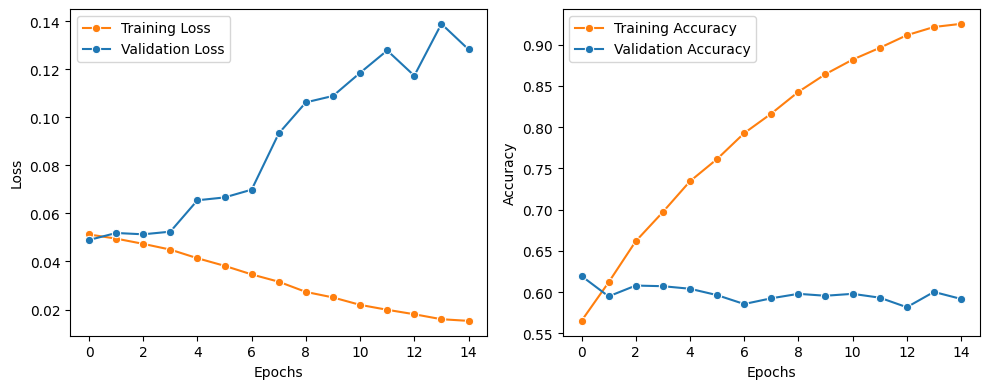

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss_list, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(valid_loss_list, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc_list, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(valid_acc_list, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# testing
model.load_state_dict(torch.load('model_lstm_1.pt'))
model.eval()
y_pred = []
with torch.no_grad():
    for input_ids, attention_mask in test_dataloader:
        input_ids = input_ids.cuda()
        output = model(input_ids)
        output = output.squeeze()
        output = output.detach().cpu().numpy()
        output = np.round(output)
        output[output < 0.5] = 0
        output[output >= 0.5] = 1
        y_pred.extend(output)
y_pred = np.array(y_pred)
        
# classification report
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

        

              precision    recall  f1-score   support

           0       0.53      0.48      0.50       553
           1       0.63      0.68      0.65       714

    accuracy                           0.59      1267
   macro avg       0.58      0.58      0.58      1267
weighted avg       0.59      0.59      0.59      1267

0.5895816890292028


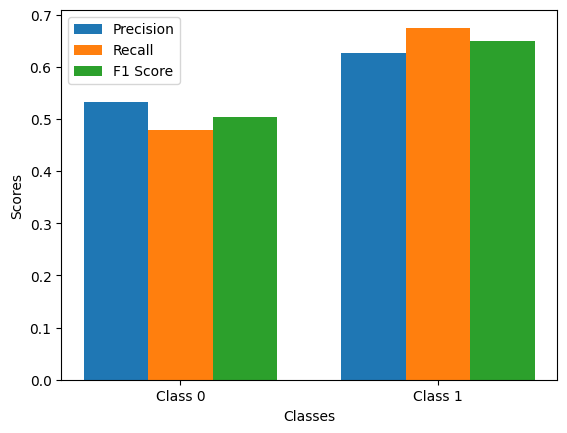

In [17]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_test and y_pred are binary labels (0 and 1)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Bar chart for Precision, Recall, and F1 Score in a single graph
bar_width = 0.25
index = np.arange(2)

plt.bar(index, precision, bar_width, label='Precision', color='tab:blue')
plt.bar(index + bar_width, recall, bar_width, label='Recall', color='tab:orange')
plt.bar(index + 2 * bar_width, f1, bar_width, label='F1 Score', color='tab:green')

plt.xlabel('Classes')
plt.ylabel('Scores')
# plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks(index + bar_width, ['Class 0', 'Class 1'])
plt.legend()
plt.show()
